In [ ]:
%load_ext autoreload
%autoreload 2

In [15]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

image_path = PROJECT_ROOT / 'ReMIND2Reg_dataset' / 'imagesTr'

from src.utils import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib

Image shape: (256, 256, 256)


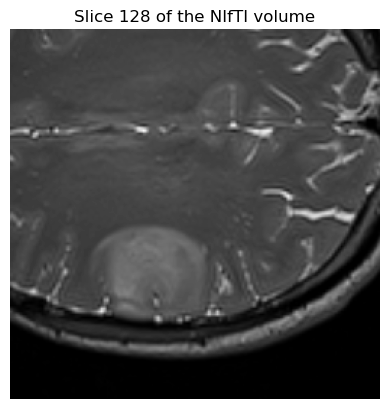

In [ ]:
iUS_file = "ReMIND2Reg_0003_0000.nii.gz"
t1_file = "ReMIND2Reg_0003_0001.nii.gz"
t2_file = "ReMIND2Reg_0003_0002.nii.gz"

# Load the NIfTI file
img_iUS = nib.load(image_path / iUS_file)
img_t1 = nib.load(image_path / t1_file)
img_t2 = nib.load(image_path / t2_file)

# Extract image data as a numpy array
img_iUS_data = img_iUS.get_fdata()
img_t1_data = img_t1.get_fdata()
img_t2_data = img_t2.get_fdata()
print("Image shape:", img_iUS_data.shape)

slice_idx = img_iUS_data.shape[2] // 2

plt.imshow(img_iUS_data[:, :, slice_idx], cmap="gray")
plt.title(f"Slice {slice_idx} of the iUS volume")
plt.axis("off")
plt.show()

plt.imshow(img_t1_data[:, :, slice_idx], cmap="gray")
plt.title(f"Slice {slice_idx} of the MRI T1 volume")
plt.axis("off")
plt.show()

plt.imshow(img_t2_data[:, :, slice_idx], cmap="gray")
plt.title(f"Slice {slice_idx} of the MRI T2 volume")
plt.axis("off")
plt.show()